# TestGrid In-Depth EDA and Clustering

_Note: This notebook can be run and experimented with directly using the "ocp-ci-analysis" image at our [jupyterhub instance](https://jupyterhub-opf-jupyterhub.apps.cnv.massopen.cloud/hub/login) hosted on the MOC._  

In our previous notebook, [TestGrid_EDA](testgrid_EDA.ipynb), we did some straightforward data access and preprocessing work in order to take a look at what data TestGrid exposes, how to access it and convert the test grids themselves into 2d arrays. While performing that initial data exploration we came up with a few more questions around how to look at this data in aggregate that we want to address here.     

In this notebook we will try and answer the following questions about the TestGrid data:

* How comparable are the TestGrids?
    
* How do we analyze the TestGrids in aggregate to learn from their combined behavior?

* How many/ which tests are the most common?
    
* Are their time series dates comparable?

* Are there sub-groups that should only be compared with one another?
    
* Is looking at the grid matrices independent of test names a valid approach for issue identification?

* What is the expected behavior of a test over time across multiple jobs.

* How does the entire test platform/specific tests perform on a given day?

* How does a test/ the entire test platform behavior evolve over time.

* Is there sufficient data here for useful ML approaches?

* Can we develop some meaningful alerting/ problem identification based on the results of the above questions?
 


In [1]:
import gzip
import json
import re
import pandas as pd
import numpy as np
from itertools import groupby
from scipy.stats import kurtosis
from scipy.signal import convolve2d
import datetime
from sklearn.linear_model import Ridge
from sklearn.cluster import DBSCAN
from sklearn.decomposition import IncrementalPCA

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={"figure.figsize": (20, 10)})
%matplotlib inline

In [2]:
# Include necessary function from TestGrid_EDA.ipynb
def decode_run_length(x):
    lst = []
    for run_length in x:
        extension = [run_length["value"]] * run_length["count"]
        lst.extend(extension)
    return lst

In [41]:
with gzip.open("../../../data/raw/testgrid_810.json.gz", "rb") as read_file:
    data = json.load(read_file)

## 1. How comparable are the TestGrids?

Lets start by answering the first question on our list, "How comparable are the TestGrids?"

TestGrids are made of a set of tests which either pass or fail over time. They are multidimensional time series where the values can take either 12 (fail), 1 (pass) or 0 (not run). There are a few other status codes used, but we will ignore them for now. We want to know if they are always the same shape, and composed of the same tests. And if not, how do they vary?     

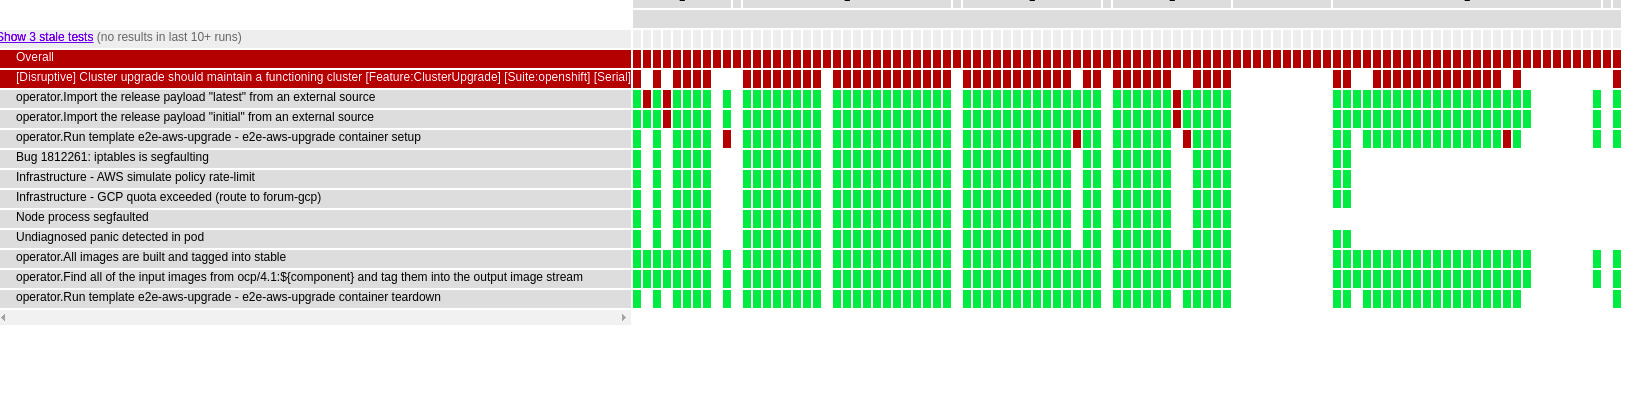

In [4]:
Image(filename="../../../docs/assets/images/testgrid_0.png")

### 1.a) Are there duplicate grids?

The first thing we will do is look at all the summaries and grid names to see if there is any overlap. Are there duplicate grids for different platforms? 

In [5]:
# count all grids and uniquely nameed grids
c = 0
grid_names = set()
for i in data.keys():
    for j in data[i].keys():
        grid_names.add(j)
        c += 1
print(len(grid_names))
print(c)

403
403


It appears as though the answer to our question, "are there duplicate grids?" is no. There a 403 individual grids by name and all grids appear to be unique. However, there seems to be a lot of similarity in naming convention between grids where only the only difference is version number. Let's remove those references and see how many groups there are and how they compare.   

### 1.b) Are there  sub-groups?

In [6]:
# count all the unique grids with version numbers removed.
c = 0
grid_names = set()
for i in data.keys():
    for j in data[i].keys():
        remove_version = re.sub(r"\d", "X", j)
        grid_names.add(remove_version)
        c += 1
print(len(grid_names))
print(c)

131
403


Great, we can now see that there are 131 grid types if we remove the version. This means that on average, a grid type is repeated about 3 times. Or stays useful for 3 versions. 

This might represent a challenge since that is a fair amount of uniqueness when it comes to making statistical claims about the behavior of these grids (since there are only 3 members of each sample). 

Now that we have identified these 131 cross-version grid types, lets look at each type and see what percent of tests they share. Can they be compared directly (do they have the same shape and tests)? 

### 1.c) Which tests do the groups all share?

In [7]:
shared_test = {}
results = []
for k in grid_names:
    k_list = []
    for i in data.keys():
        for j in data[i].keys():
            remove_version = re.sub(r"\d", "X", j)
            if remove_version == k:
                k_list.append([x["name"] for x in data[i][j]["grid"]])

    total_tests = len(set([item for sublist in k_list for item in sublist]))

    for g, l in enumerate(k_list):
        if g == 0:
            intersect = set(l)
        else:
            intersect = intersect.intersection(set(l))

    shared_test[k] = intersect
    if len(k_list) > 1:
        values = (k, len(k_list), len(intersect), total_tests)
        results.append(values)
results = pd.DataFrame(
    results, columns=["group", "num_grids", "num_shared_test", "total_tests"]
)
results

,group,num_grids,num_shared_test,total_tests
0,release-openshift-origin-installer-eXe-aws-ser...,7,34,227
1,release-openshift-ocp-installer-eXe-openstack-X.X,6,3,3052
2,release-openshift-ocp-installer-eXe-gcp-ovn-X.X,5,3,2915
3,release-openshift-origin-installer-eXe-gcp-sha...,5,36,2609
4,release-openshift-origin-installer-eXe-aws-cal...,3,12,15
...,...,...,...,...
72,release-openshift-origin-installer-eXe-gcp-upg...,3,19,126
73,release-openshift-origin-installer-eXe-aws-com...,5,6,2494
74,release-openshift-ocp-installer-eXe-gcp-rt-X.X,4,3,1212
75,promote-release-openshift-machine-os-content-e...,5,1,1


In [8]:
results["perc_coverage"] = results["num_shared_test"] / results["total_tests"]
results.describe()

,num_grids,num_shared_test,total_tests,perc_coverage
count,77.000000,77.000000,77.000000,72.000000
mean,4.532468,56.610390,1224.428571,0.195229
std,1.658982,173.945481,1205.698175,0.309903
min,2.000000,0.000000,0.000000,0.000000
25%,3.000000,3.000000,92.000000,0.002397
50%,5.000000,9.000000,551.000000,0.014575
75%,6.000000,36.000000,2534.000000,0.206321
max,7.000000,953.000000,3462.000000,1.000000


For each grid type there is between 1 and 7 individual grids, and for the vast majority of these types, there is very little overlap in the tests used across them all. There appear to be some exceptions, here that we can look into more closely later on. But as far as addressing the question "how comparable are the grids". I think the answer hear appears to be, not very.   

Therefore, analyzing the behavior of our jobs based on comparing grids (if we assume tests as the fundamental unit of these grids) does not appear to be a reasonable approach. We may still be able to do this looking purely at the grid patterns independent of tests names, but this will be explored further below. 

## 2. How comparable are individual tests?

Lets ignore the grids as whole units for a minute and examine the occurrence of specific tests. Which are the most common? How many many unique tests are there? How should we expect them to behave?  

### 2.a) What are the  most common tests? 

In [9]:
# Count the number of tests present across the entire platform
all_tests = []
for i in data.keys():
    for j in data[i].keys():
        tests = [x["name"] for x in data[i][j]["grid"]]
        all_tests.append(tests)

all_tests = [item for sublist in all_tests for item in sublist]

In [10]:
len(all_tests)

177291

In [11]:
# This tells us what percent a specific test is present across all grids.
# Where c is the total number of tests.
pd.Series(all_tests).value_counts() / c

Overall                                                                                                                                                                                                                             0.915633
operator.All images are built and tagged into stable                                                                                                                                                                                0.786600
operator.Import the release payload "latest" from an external source                                                                                                                                                                0.751861
operator install network                                                                                                                                                                                                            0.533499
operator install machine-config                     

In [12]:
# This tells us the count of a specific test and filters only for tests that occur at least 10 times
test_counts = pd.Series(all_tests).value_counts()
test_counts[test_counts.values > 10]

Overall                                                                                                                                                                                                            369
operator.All images are built and tagged into stable                                                                                                                                                               317
operator.Import the release payload "latest" from an external source                                                                                                                                               303
operator install network                                                                                                                                                                                           215
operator install machine-config                                                                                                             

We can see above that there are **177,291 test instances** across all **403 grids**. Of those tests, there are only **7,798 unique tests** which is over a **~20x reduction**. 

Somewhat contrary to the findings in the earlier section, this tells us that there is a fair amount of overlap of tests among grids. Perhaps our criteria for comparison above was too strict, and we should employ some more fuzzy matching methods. 

We can also see that of these ~7k unique tests, 3,137 (about 1/3) occur across at least 10 grids. So it is probably this subset that we could use for comparisons and determining average behavior of a test overtime. 

Let's look at one of the most common tests and see what we can say about its overall behavior. 

### 2.b) Single Test Behavior Analysis 

We will use "operator.All images are built and tagged into stable" since it looks like it impacts ~80% of our grids. 

In [13]:
target_test = "operator.All images are built and tagged into stable"

In [14]:
collected_target_tests = []
timestamps = []
for i in data.keys():
    for j in data[i].keys():
        grid = data[i][j]["grid"]

        if len(grid) == 0:
            continue
        if target_test in [x["name"] for x in grid]:
            test_data = [
                x["statuses"] for x in grid if x["name"] == target_test
            ]
            collected_target_tests.append(test_data)
            timestamps.append(data[i][j]["timestamps"])

In [15]:
def get_timeseries_by_name(data, test_name):
    collected_target_tests = []
    timestamps = []
    for i in data.keys():
        for j in data[i].keys():
            grid = data[i][j]["grid"]

            if len(grid) == 0:
                continue
            if test_name in [x["name"] for x in grid]:
                test_data = [
                    x["statuses"] for x in grid if x["name"] == test_name
                ]
                collected_target_tests.append(test_data)
                timestamps.append(data[i][j]["timestamps"])
    ts_data = pd.DataFrame(
        zip(collected_target_tests, timestamps), columns=["values", "time"]
    )
    ts_data["values"] = (
        ts_data["values"].apply(lambda x: x[0]).apply(decode_run_length)
    )
    ts_data["time"] = ts_data["time"].apply(lambda x: (np.array(x) // 1000))
    ts_data["time"] = ts_data["time"].apply(
        lambda x: [datetime.datetime.fromtimestamp(y) for y in x]
    )

    return ts_data

In [16]:
print(len(collected_target_tests))
print(len(timestamps))

317
317


Great, this particular test has 317 examples, which means of the 403 grids its used in 78%. Let see if we have roughly the same number of samples for each instance of this test. 

In [17]:
pd.DataFrame(collected_target_tests, columns=["RL"])["RL"].apply(
    decode_run_length
).apply(len)

0      118
1      867
2      181
3       15
4       15
      ... 
312     32
313    104
314     30
315     23
316     50
Name: RL, Length: 317, dtype: int64

So we can see from the above output that the we have a very different number of data points for a test depending on which grid it is associated with. This again, creates a problem for making direct comparisons between these tests. 

But that's alright, there are a number of ways this issue can be addressed. For now, lets go ahead, and generate some statistics about each time series. We can then define "normal behavior" as the average of these statistics as an initial naive approach to comparing tests in aggregate. 

In [18]:
# Create a dataframe for all of the "operator.All images are built and tagged into stable" time series data
ts_data = pd.DataFrame(
    zip(collected_target_tests, timestamps), columns=["values", "time"]
)

In [19]:
ts_data["values"] = (
    ts_data["values"].apply(lambda x: x[0]).apply(decode_run_length)
)
ts_data["time"] = ts_data["time"].apply(lambda x: (np.array(x) // 1000))
ts_data["time"] = ts_data["time"].apply(
    lambda x: [datetime.datetime.fromtimestamp(y) for y in x]
)

In [20]:
ts_data.head(1)

,values,time
0,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...","[2020-10-08 20:48:05, 2020-10-08 19:12:01, 202..."


0.940677966101695% pass 



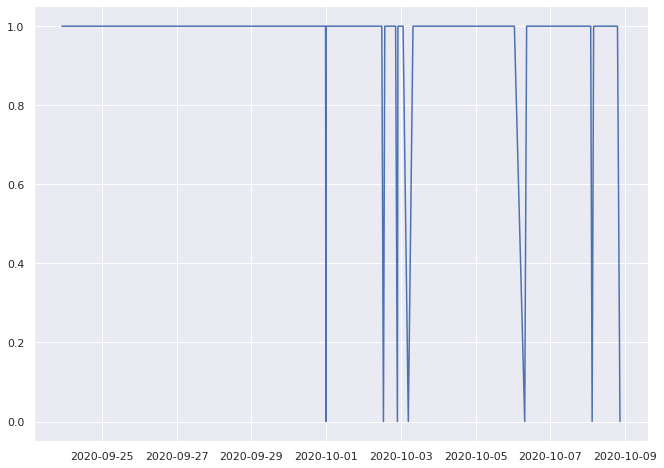



0.9319492502883506% pass 



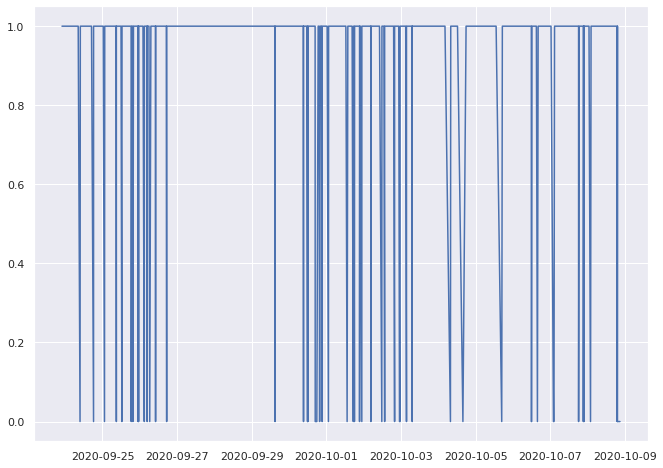



0.9668508287292817% pass 



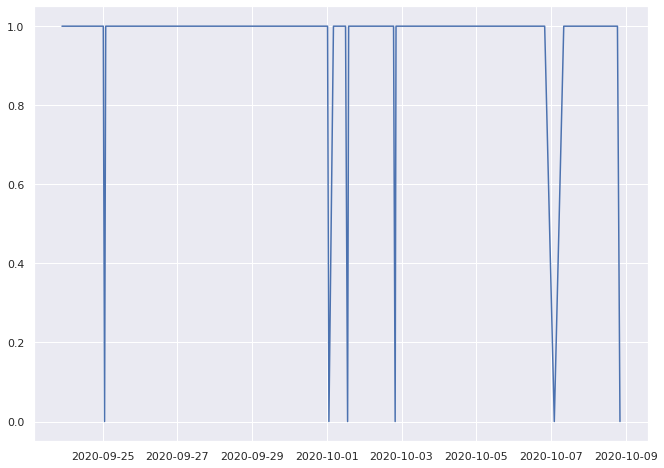



0.7333333333333333% pass 



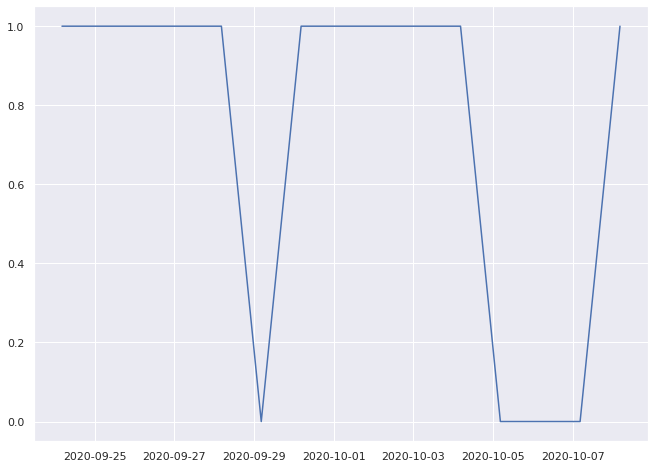



1.0% pass 



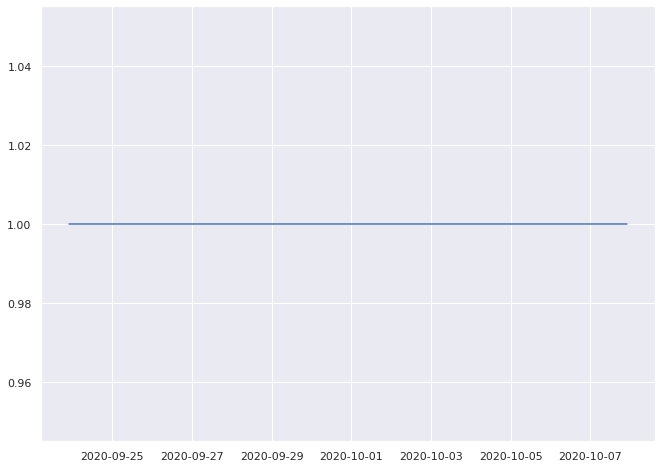



1.0% pass 



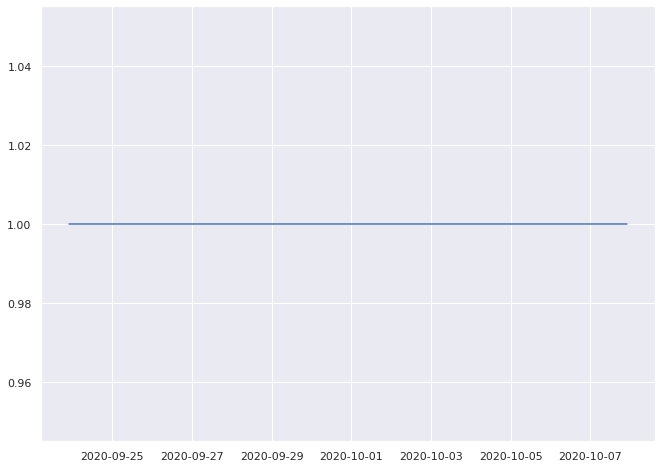



0.9333333333333333% pass 



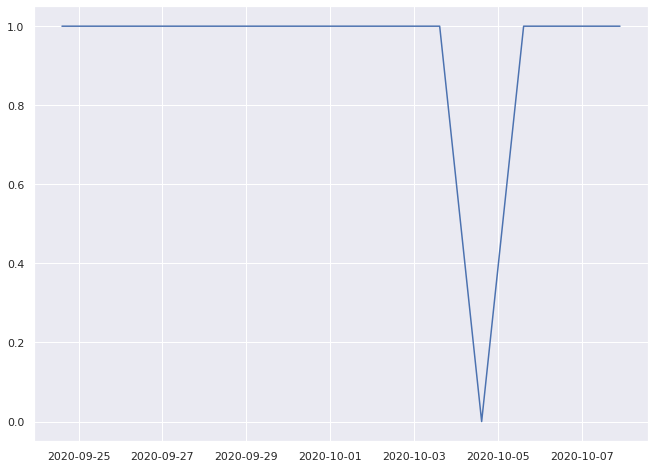



1.0% pass 



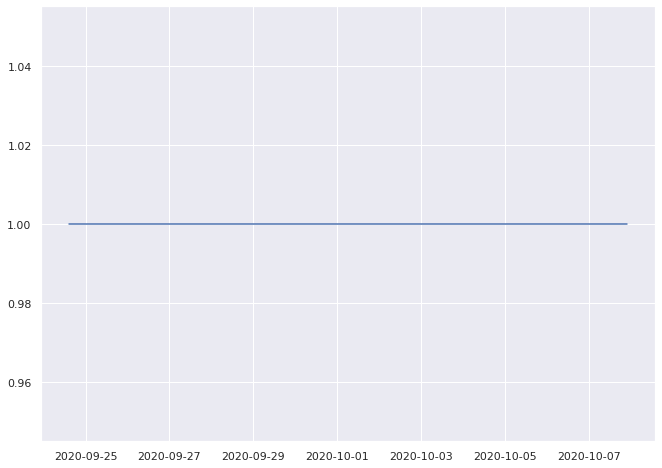



0.8333333333333334% pass 



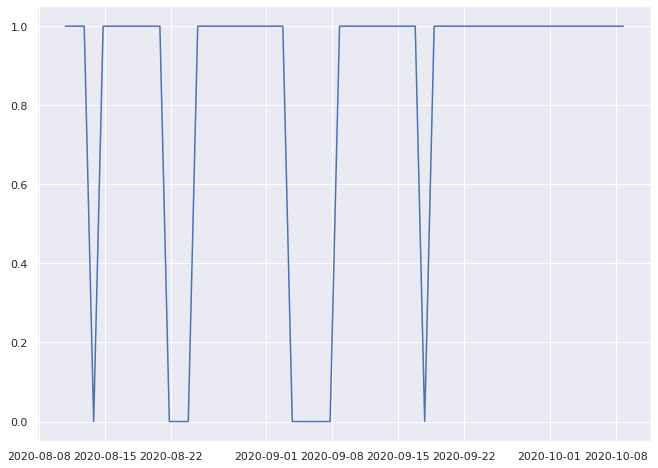



0.8333333333333334% pass 



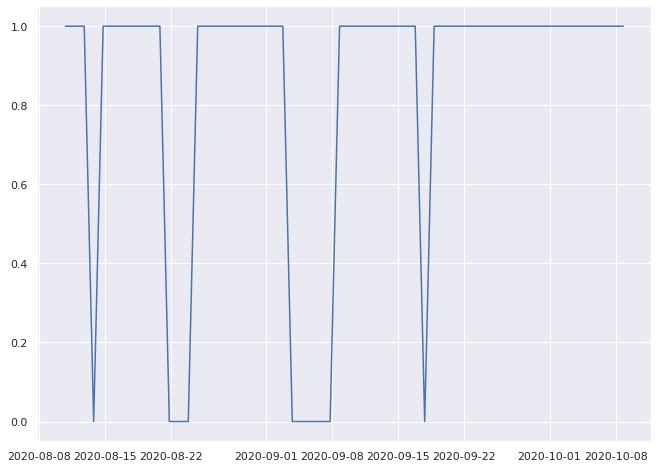

In [21]:
### Plot the first ten time series to see what we are working with

sns.set(rc={"figure.figsize": (11, 8)})
for i in range(len(ts_data))[0:10]:
    print(
        f"{sum(ts_data.loc[i,'values'])/len(ts_data.loc[i,'values'])}% pass \n"
    )
    plt.plot(ts_data.loc[i, "time"], ts_data.loc[i, "values"])
    plt.show()
    print("\n")

Since these time series are of unequal length, and we want to encode their general behavior to make comparisons, lets convert each of them into a vector of features based on some statistical properties of the time series. 

Selected Features
* pass rate
* regression slope
* regression intercept
* longest failure streak ratio
* kurtosis ratio
* largest frequency ratio

There are obviously many ways to convert time series into a fixed length feature vector. But we'll use these as I think they are fairly interesting and will allow us to move forward. **But I encourage future contributors to question/update/change these selected features. :)**

In [22]:
# Functions for calculating each feature from the time seires.


def get_regression_coefs(data):
    lr = Ridge()
    x = np.array(range(len(data))).reshape(-1, 1)
    y = np.array(data).reshape(-1, 1)
    lr.fit(x, y)
    line = lr.predict(x)
    return lr.coef_, line[0]


def longest_failure_streak(x):
    prev_streak = 0
    for n, c in groupby(x):
        if n == 12:
            count = sum(1 for i in c)
            if count > prev_streak:
                prev_streak = count

    return prev_streak


def largest_frequncy(x):
    f = np.fft.fft(x).real / len(x)
    f = f[range(int(len(x) / 2))]
    if len(f[1:]) > 0:
        return f[1:].argmax() / len(x)
    else:
        return 0

In [23]:
def get_test_individual_behavior(test):
    description = []
    for i, ts in enumerate(test):
        pass_rate = sum([x for x in ts if x == 1]) / len(ts)
        coef, intercept = get_regression_coefs(ts)
        failure_streak = longest_failure_streak(ts) / len(ts)
        kurtosiss = kurtosis(ts) / len(ts)
        frequency = largest_frequncy(ts)
        description.append(
            (
                pass_rate,
                float(coef),
                float(intercept),
                failure_streak,
                kurtosiss,
                frequency,
            )
        )

    return description

In [24]:
indivudial_metric = pd.DataFrame(
    get_test_individual_behavior(ts_data["values"]),
    columns=[
        "pass_rate",
        "slope",
        "intercept",
        "failures_streak",
        "kurtosis",
        "frequency",
    ],
)

In [25]:
indivudial_metric

,pass_rate,slope,intercept,failures_streak,kurtosis,frequency
0,0.940678,0.001494,0.853298,0.0,0.101019,0.161017
1,0.931949,0.000109,0.884678,0.0,0.011266,0.085352
2,0.966851,0.000391,0.931698,0.0,0.139232,0.016575
3,0.733333,0.046263,0.409490,0.0,-0.059091,0.200000
4,1.000000,0.000000,1.000000,0.0,-0.200000,0.000000
...,...,...,...,...,...,...
312,0.968750,0.002382,0.931832,0.0,0.844758,0.250000
313,0.990385,0.000549,0.962088,0.0,0.952016,0.298077
314,0.966667,-0.004225,1.027930,0.0,0.834483,0.066667
315,0.782609,0.002962,0.750032,0.0,-0.005314,0.304348


We've now converted our 317 variable length binary time series data into a tabular data set with 6 features that represent the behavior of our tests over time. The benefit of doing this is that we can now apply some classic machine learning approaches, like  dimensionality reduction and clustering to our data.  

Lets visualize the instances of this test and see if any obvious structure jumps out.  

#### Visualizing our tests

First we will apply PCA to reduce our 6 dimensional data down to 2 for visualization purposes. Then we will apply DBSCAN to identify any clusters or outliers that might be present in our data. 

In [26]:
X = indivudial_metric
ipca = IncrementalPCA(n_components=2, batch_size=10)
ipca.fit(X)
two_d = ipca.transform(X)

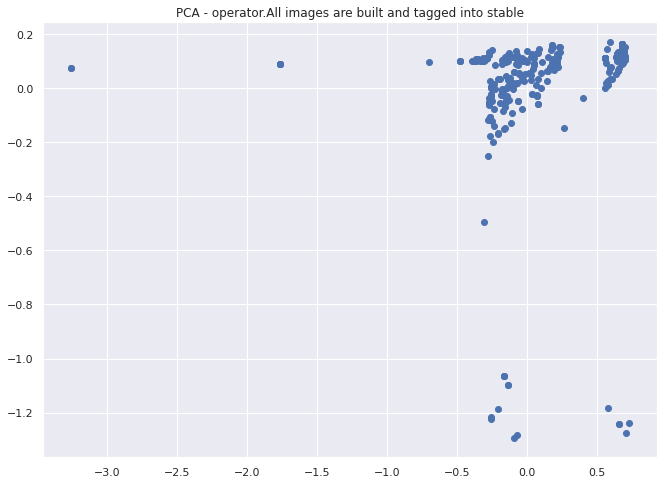

In [27]:
plt.scatter(two_d[:, 0], two_d[:, 1])
plt.title("PCA - operator.All images are built and tagged into stable")
plt.show()

In [28]:
X = indivudial_metric
cluster = DBSCAN().fit(X)
cluster.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  2,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        3,  3,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  3,  3,  0,  0,  0,  0,  2,
        0,  0,  0,  0,  0

#### Saving the cluster model

In [29]:
import pickle
pickle.dump(cluster, open('dbscan_model.pkl', 'wb'))

In [30]:
loaded_model = pickle.load(open('dbscan_model.pkl', 'rb'))
print(loaded_model)
loaded_model.labels_

DBSCAN()


array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  2,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        3,  3,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  3,  3,  0,  0,  0,  0,  2,
        0,  0,  0,  0,  0

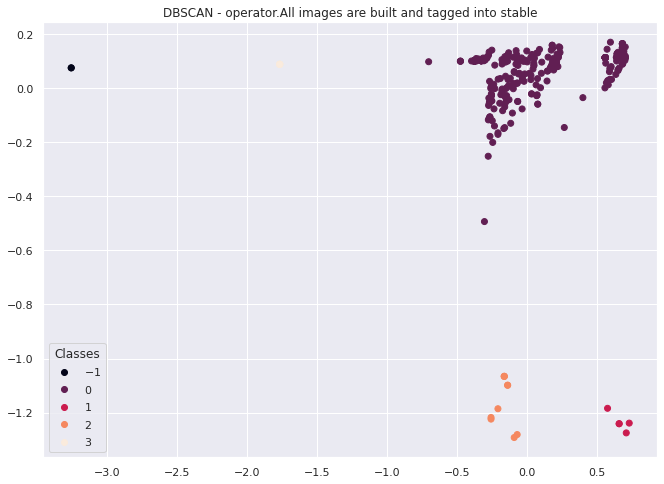

In [31]:
fig, ax = plt.subplots()
scatter = ax.scatter(two_d[:, 0], two_d[:, 1], c=cluster.labels_)
legend1 = ax.legend(
    *scatter.legend_elements(), loc="lower left", title="Classes"
)
plt.title("DBSCAN - operator.All images are built and tagged into stable")
plt.show()

It looks like this method works to cluster individual test behavior across multiple instances of the same test. In this case we have divide the space into 4 clusters with a couple of outliers that we could investigate further.

For the purposes of this notebook,we have established at least one method for encoding and categorizing the behavior of tests that are all of the same type. We will now move on to another topic. 

In the future this could be used to classify different types of observed errors for tests found in TestGrids

### 2.c) Multiple Test Behavior 

Lets just quickly take a look at a larger portion of th entire data set that we have and see if we notice anything from clustering across multiple tests, i.e. are there types of behavior clusters we can identify.

_note: Using all 117k tests is rather slow, so I'll limit it only to ~12k from the first 200 grids for the purposes of this notebook_ 

In [32]:
first_pass = True

for i in all_tests[1:200]:
    if first_pass:
        tsx = get_timeseries_by_name(data, i)
        tsx["name"] = i
        first_pass = False
    else:
        next_ts = get_timeseries_by_name(data, i)
        next_ts["name"] = i
        tsx = tsx.append(next_ts, ignore_index=True)

In [33]:
tsx.shape

(11927, 3)

In [34]:
indivudial_metric = pd.DataFrame(
    get_test_individual_behavior(tsx["values"]),
    columns=[
        "pass_rate",
        "slope",
        "intercept",
        "failures_streak",
        "kurtosis",
        "frequency",
    ],
)

In [35]:
indivudial_metric.head()

,pass_rate,slope,intercept,failures_streak,kurtosis,frequency
0,0.016949,-0.036272,3.765972,0.016949,0.021369,0.084746
1,0.237601,0.001266,1.793203,0.008074,0.000992,0.003460
2,0.000000,-0.076442,10.962582,0.372881,-0.015939,0.237288
3,0.000000,-0.024003,10.001448,0.166667,-0.008263,0.000000
4,0.000000,-0.056302,12.105453,0.388889,0.002778,0.022222


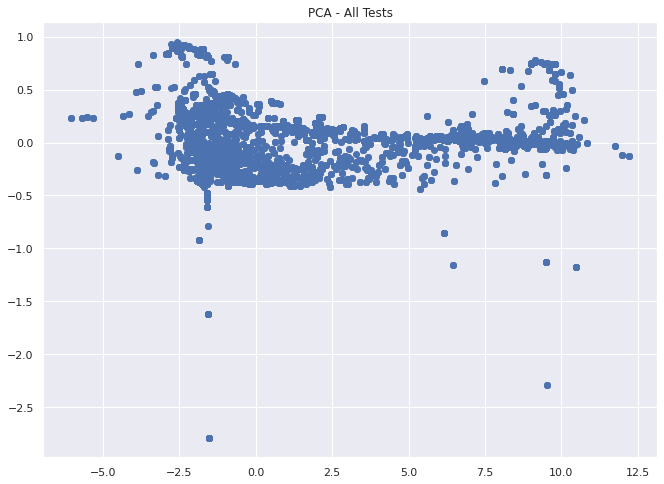

In [36]:
X = indivudial_metric
ipca = IncrementalPCA(n_components=2, batch_size=10)
ipca.fit(X)
two_d = ipca.transform(X)
plt.scatter(two_d[:, 0], two_d[:, 1])
plt.title("PCA - All Tests")
plt.show()

In [37]:
X = indivudial_metric
cluster = DBSCAN().fit(X)
len(cluster.labels_)

11927

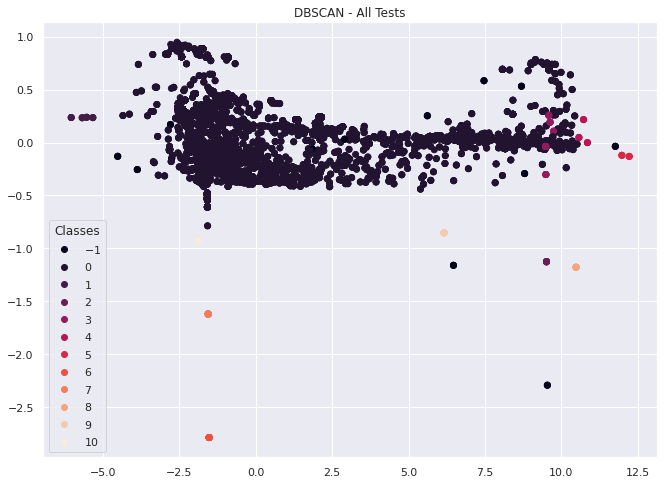

In [38]:
fig, ax = plt.subplots()
scatter = ax.scatter(two_d[:, 0], two_d[:, 1], c=cluster.labels_)
legend1 = ax.legend(
    *scatter.legend_elements(), loc="lower left", title="Classes"
)
plt.title("DBSCAN - All Tests")
plt.show()

Based on the image above, its looks like we get something close to a 2d uniform distribution of our dataset with a few outliers and smaller clusters when we take a larger portion of our tests at once with this feature set. 

This might be noise or it might show that most time series behave in a similar way, or cluster into one of the other 10 failure types.  

In either case, we can use these methods outlined above to investigate this approach further in a later notebook.

### 2.d)  Comparing tests in aggregate 

Now that we've looked at individual tests, lets derive a new object that describes a single test as the aggregation of the features we've defined above for every instance of the same test. 

In [39]:
def get_test_behavior(test):
    description = {}
    pass_rate = 0
    avg_coef = 0
    avg_intercept = 0
    avg_failure_streak = 0
    avg_kurtosis = 0
    avg_frequency = 0
    for i, ts in enumerate(test):
        pass_rate += sum([x for x in ts if x == 1]) / len(ts)
        coef, intercept = get_regression_coefs(ts)
        avg_coef += coef
        avg_intercept += intercept
        avg_failure_streak += longest_failure_streak(ts) / len(ts)
        avg_kurtosis += kurtosis(ts) / len(ts)
        avg_frequency += largest_frequncy(ts)

    description["pass_rate"] = pass_rate / (i + 1)
    description["avg_coef"] = float(avg_coef / (i + 1))
    description["avg_intercept"] = float(avg_intercept / (i + 1))
    description["avg_failure_streak"] = avg_failure_streak / (i + 1)
    description["avg_kurtosis"] = avg_kurtosis / (i + 1)
    description["avg_frequency"] = avg_frequency / (i + 1)

    return description

In [40]:
single_test = get_timeseries_by_name(
    data, "operator.All images are built and tagged into stable"
)
get_test_behavior(single_test["values"])

{'pass_rate': 0.911815196098699,
 'avg_coef': -0.00031722304811730484,
 'avg_intercept': 0.9199496749854382,
 'avg_failure_streak': 0.0,
 'avg_kurtosis': 0.25686846515261513,
 'avg_frequency': 0.1669826612570952}

Alright, this looks like it might be a reasonable representation for a summary of expected behavior for a test. What can this tell us? 

For the test "operator.All images are built and tagged into stable" we should expect this test to pass about 91% percent of the time regardless of the platform its run on. We have a small negative slope (avg_coef), which means on average we have more "not run" instances as we move forward in time, but this is such a small slope its practically flat, i.e., this is a reliable test. If it does fail, there is 0% average failure streak, meaning if it does fail, it could fail for up to 0% of the total number of tests runs to date in a row (i.e, this test never fails, seems to only pass or not run). This value basically tells us how often we see small flips vs longer outages in our data. Finally, kurtosis and frequency are two additional measures of "steadiness" of our data, but since they are normalized here their interpretation is less direct, but can be understood in relation to other test vectors.

**What have we accomplished up to now?**

So far we have looked at the girds as a whole based on their shared collection of tests, determined that that the grids themselves are all unique and not directly comparable with regard to their set of tests. 

However, some tests are repeated across many grids and we showed a couple methods to visualize, encode and analyze them both individually and in aggregate.    

## Conclusion

In this notebook, we have done some additional exploration of the TestGrid data; familiarized ourselves with it further and determined a number of facts about the nature of the grids that will help us move forward developing additional analysis and ML tools for CI. We have looked at the entire TestGrid platform, individual grids and individual tests both from a stationary and time-series perspective. We have also done a couple of small experiments with encoding and clustering to explore the dataset's viability for applying ML approaches.